<a href="https://colab.research.google.com/github/silverstar0727/1day-1commit-challenge/blob/master/machine_learning_ch16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# google drive와 연동
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 연동 테스트 코드
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')

!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [0]:
!pip install pyprind

In [0]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np

df = pd.read_csv('/content/gdrive/My Drive/machine_learning/ch16/movie_data.csv', encoding = 'utf-8')

In [0]:
df.head()
# df에는 review와 sentiment의 두개의 칼럼이 존재한다

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [0]:
# 텍스트를 정수로 인코딩해야함
# collection 패키지의 Counter를 사용
from collections import Counter

counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), title = '단어의 등장 횟수를 카운트 함')

for i, review in enumerate(df['review']):
  text = ''.join([c if c not in punctuation else ' '+c+' ' for c in review]).lower()
  df.loc[i, 'review'] = text
  
  pbar.update()
  counts.update(text.split())

# 단어를 정수로 매핑하는 딕셔너리 생성
word_counts = sorted(counts, key = counts.get, reverse = True)
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), title = '리뷰를 정수로 매핑함')

for review in df['review']:
  mapped_reviews.append([word_to_int[word] for word in review.split()])
  pbar.update()

단어의 등장 횟수를 카운트 함
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:35
리뷰를 정수로 매핑함
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [0]:
# sequence 크기를 지정
## 동일 시퀀스를 만듦
## 시퀀스 길이가 200보다 작으면 왼쪽에 0을패딩
## 시퀀스 길이가 200보다 크면 마지막 200개만 사용

# sequence length는 hyperparameter로 나중에 조정을 할 필요가 있음
sequence_length = 200
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype = int)

for i, row in enumerate(mapped_reviews):
  review_arr = np.array(row)
  sequences[i, -len(row):] = review_arr[-sequence_length:]

In [0]:
# data split
X_train = sequences[:37500, :]
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:, :]
y_test = df.loc[37500:, 'sentiment'].values

In [0]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [0]:
n_words = len(word_to_int) + 1
print(n_words)

102967


## embedding
실수값을 가진 고정된 벡터로 표현...
이론적으로 -1과 1사이의 무한한 실수를 이용한다

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

tf.__version__

'2.1.0'

In [0]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(n_words, 200, embeddings_regularizer = 'l2'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


## RNN 모델 만들기

In [0]:
# LSTM층 사용 
# 16개의 순환유닛을 사용
model.add(layers.LSTM(16))

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         20593400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                13888     
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
# training
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [0]:
# 모델 저장
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath = 'sentiment_rnn_checkpoint.h5', monitor = 'val_loss', 
                                 save_best_only = True),
                 TensorBoard(log_dir = 'sentiment_rnn_logs/{}'.format(time.asctime()))]

In [0]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_split = 0.3, 
                    callbacks = callback_list)

Train on 26250 samples, validate on 11250 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


26250/26250 [==============================] - 148s 6ms/sample - loss: 6.5649 - acc: 0.6684 - val_loss: 0.7360 - val_acc: 0.7825
Epoch 2/10
26250/26250 [==============================] - 136s 5ms/sample - loss: 0.6629 - acc: 0.8126 - val_loss: 0.6868 - val_acc: 0.8024
Epoch 3/10
26250/26250 [==============================] - 134s 5ms/sample - loss: 0.5888 - acc: 0.8381 - val_loss: 0.5509 - val_acc: 0.8564
Epoch 4/10
26250/26250 [==============================] - 129s 5ms/sample - loss: 0.5377 - acc: 0.8569 - val_loss: 0.5175 - val_acc: 0.8535
Epoch 5/10
26250/26250 [==============================] - 128s 5ms/sample - loss: 0.5053 - acc: 0.8649 - val_loss: 0.4970 - val_acc: 0.8654
Epoch 6/10
26250/26250 [==============================] - 127s 5ms/sample - loss: 0.4782 - acc: 0.8716 - val_loss: 0.5043 - val_acc: 0.8568
Epoch 7/10
26250/26250 [==============================] - 127s 5ms/sample - loss: 0.4567 - acc: 0.8829 - val_loss: 0.4637 - val_acc: 0.8768
Epoch 8/10
26250/26250 [=======

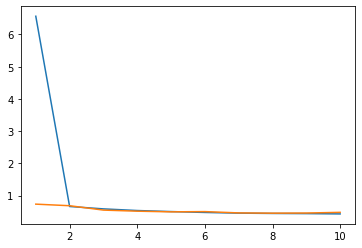

In [0]:
# 시각화
import matplotlib.pyplot as plt

epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.show()

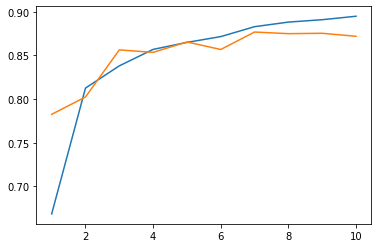

In [0]:
# 정확도
epochs = np.arange(1, 11)

plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.show()

In [0]:
# 평가
model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)

12500/12500 [==============================] - 19s 2ms/sample - loss: 0.4619 - acc: 0.8737


[0.4619261918544769, 0.87368]

In [0]:
model.predict_proba(X_test[:10])

array([[0.01035459],
       [0.01080024],
       [0.00227229],
       [0.96289384],
       [0.9482234 ],
       [0.98677444],
       [0.01697485],
       [0.95750934],
       [0.00433393],
       [0.85623246]], dtype=float32)

In [0]:
model.predict_classes(X_test[:10])

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)